In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
%cd /content/drive/Othercomputers/Lenovo/BINUS/SKRIPSI/PRE THESIS/CODES

# %cd /content/drive/MyDrive/CODES

/content/drive/Othercomputers/Lenovo/BINUS/SKRIPSI/PRE THESIS/CODES


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls

 01b_bertopic_cleaning_eda_preprocessing.ipynb
 01_cleaning_eda_preprocessing.ipynb
 02a_modeling_sentiment_prediction.ipynb
 02b_modeling_topic_modeling.ipynb
 df_modeling_bertopic.csv
 df_modeling.csv
 exclude_words.py
 mapping_dictionary.py
'Normalization Dictionary [Explained].gsheet'
 normalization_dictionary.py
 __pycache__
 results
 stopwords.txt
 tes-bertopic.ipynb


# **Import Libraries and Prepare Dataset**

In [6]:
!pip install -q nlp_id stanza Levenshtein

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.3/484.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━

In [7]:
!pip install -q --upgrade git+https://github.com/ariaghora/mpstemmer.git

  Preparing metadata (setup.py) ... done


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import re
import nltk
nltk.download('punkt_tab')

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", None)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
url = (
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vQx0P59eV_KGGFJe-l86dgsz9pZRehTRJoOP_tyVXbrQPtzmD97E1lZ0lgFJ-ATVTT9HkBRX5g1kRKB/pub?output=csv"
)
df = pd.read_csv(url)
print(df.shape)

(301, 7)


In [10]:
df_melt = df.melt(
    value_vars=[
        "Apa yang Anda sukai selama masa perkuliahan Anda?",
        "Apa yang Anda tidak sukai selama masa perkuliahan Anda?"
    ],
    var_name='sentiment',
    value_name='text'
)

sentiment_map = {
    "Apa yang Anda sukai selama masa perkuliahan Anda?": 'positive',
    "Apa yang Anda tidak sukai selama masa perkuliahan Anda?": 'negative'
}
df_melt['sentiment'] = df_melt['sentiment'].map(sentiment_map)

df_preprocess = df_melt[['text', 'sentiment']]

# **Exploratory Data Analysis**

## **EDA Persebaran Responden**

In [ ]:
df_demografis = df[['Asal Kampus', 'Jurusan', 'Kota Asal Universitas', 'Tahun Masuk Kuliah']]

In [ ]:
from mapping_dictionary import university_mapping
from mapping_dictionary import city_mapping
from mapping_dictionary import program_mapping

def standardize_university_name(name):
    if pd.isna(name):
        return name
    name = str(name).lower()
    name = re.sub(r'[^\w\s]', '', name) # Remove punctuation
    name = re.sub(r'\bthe\b', '', name) # Remove 'the'
    name = re.sub(r'\band\b', '', name) # Remove 'and'
    name = re.sub(r'\s+', ' ', name).strip() # Remove extra spaces
    return name

def apply_mapping(text, mapping_dict):
    if not isinstance(text, str):
        return None
    text_lower = text.lower()
    for pattern, mapped_value in mapping_dict.items():
        if re.search(pattern, text_lower, flags=re.IGNORECASE):
            return mapped_value
    return None  # No match found

In [ ]:
df_demografis['Asal Kampus'] = df_demografis['Asal Kampus'].apply(standardize_university_name)

df_demografis['Mapped_University'] = df_demografis['Asal Kampus'].apply(lambda x: apply_mapping(x, university_mapping))
df_demografis['Mapped_City'] = df_demografis['Kota Asal Universitas'].apply(lambda x: apply_mapping(x, city_mapping))
df_demografis['Mapped_Program'] = df_demografis['Jurusan'].apply(lambda x: apply_mapping(x, program_mapping))

In [ ]:
unmapped_universities = df_demografis[df_demografis['Mapped_University'].isna()]['Asal Kampus'].unique()
unmapped_cities = df_demografis[df_demografis['Mapped_City'].isna()]['Kota Asal Universitas'].unique()
unmapped_programs = df_demografis[df_demografis['Mapped_Program'].isna()]['Jurusan'].unique()

print(f"\nUnmapped universities ({len(unmapped_universities)}):")
for u in unmapped_universities:
    print(f"- {u}")

print(f"\nUnmapped cities ({len(unmapped_cities)}):")
for c in unmapped_cities:
    print(f"- {c}")

print(f"\nUnmapped programs ({len(unmapped_programs)}):")
for p in unmapped_programs:
    print(f"- {p}")


Unmapped universities (2):
- universitas tarumanegara
- kalbis university

Unmapped cities (0):

Unmapped programs (2):
- Arsitektur
- Master Track of Information Technology


In [ ]:
def plot_distribution(df, column, title, threshold=None,
                      color='skyblue', xlabel='Kategori', ylabel='Jumlah',
                      show_percentage=True, sort_index=False):

    counts = df[column].value_counts()
    if sort_index:
        counts = counts.sort_index()

    total = counts.sum()

    # Apply threshold if provided
    if threshold is not None:
        main = counts[counts / total >= threshold]
        others = counts[counts / total < threshold].sum()
        if others > 0:
            counts = pd.concat([main, pd.Series({'Others': others})])

    labels = counts.index.astype(str)
    sizes = counts.values
    percentages = (sizes / total * 100).round(1)

    # Plot
    plt.figure(figsize=(12, 10))
    bars = plt.bar(labels, sizes, color=color, edgecolor='black')

    for bar, size, pct in zip(bars, sizes, percentages):
        label = f'{pct:.1f}% ({size})' if show_percentage else f'{size}'
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 label, ha='center', va='bottom', fontsize=12)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=14)
    plt.tight_layout()
    plt.show()


### **1. Persebaran Responden berdasarkan Universitas**

In [ ]:
df_demografis['Mapped_University'].nunique()

39

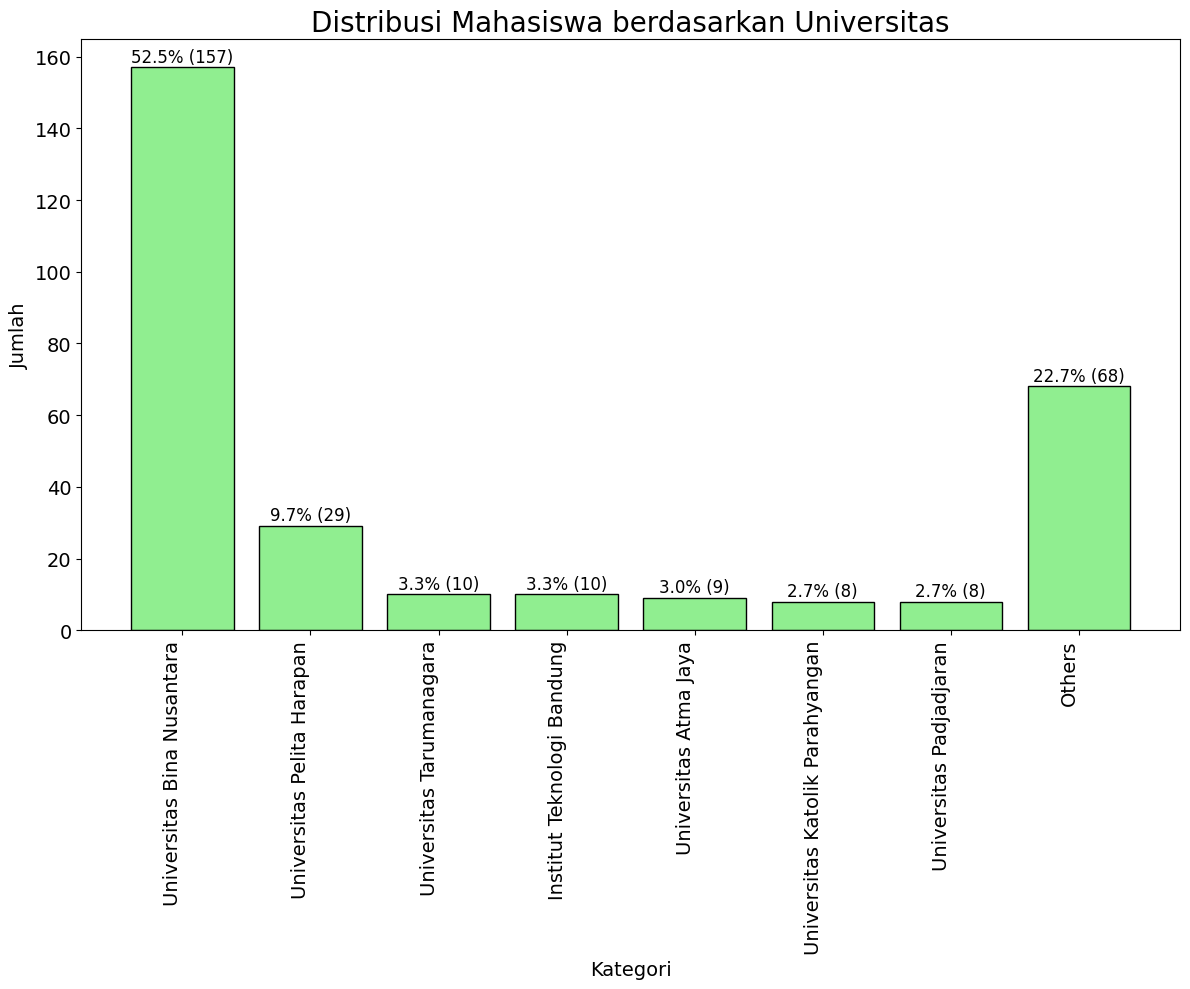

In [ ]:
plot_distribution(df_demografis,
                  column='Mapped_University',
                  title='Distribusi Mahasiswa berdasarkan Universitas',
                  threshold=0.025,
                  color='lightgreen',
                  sort_index=False)

### **2. Persebaran Responden berdasarkan Tahun Masuk Kuliah**

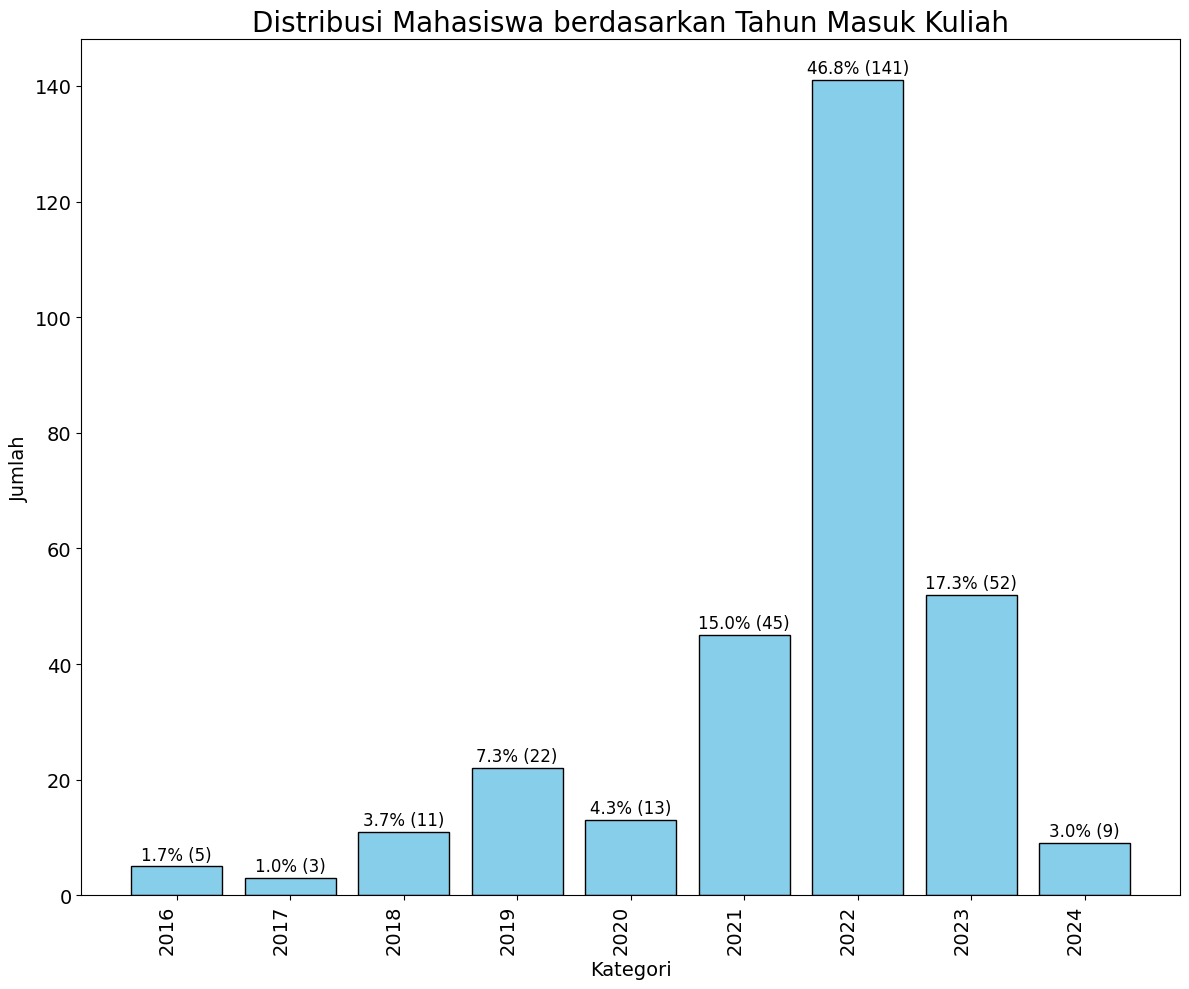

In [ ]:
plot_distribution(df_demografis,
                  column='Tahun Masuk Kuliah',
                  title='Distribusi Mahasiswa berdasarkan Tahun Masuk Kuliah',
                  threshold=None,
                  color='skyblue',
                  sort_index=True)

### **3. Persebaran Responden berdasarkan Asal Kota Universitas**

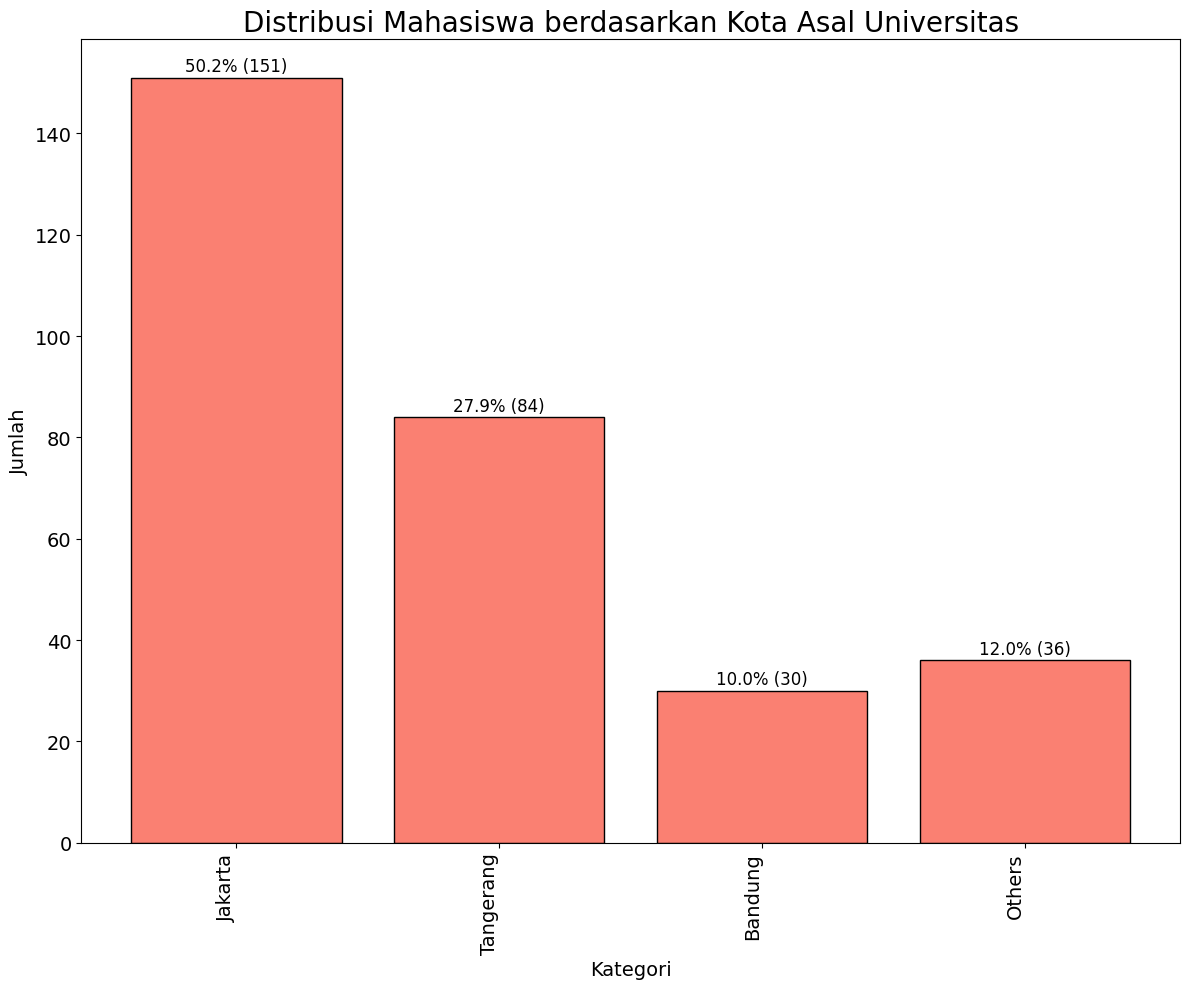

In [ ]:
plot_distribution(df_demografis,
                  column='Mapped_City',
                  title='Distribusi Mahasiswa berdasarkan Kota Asal Universitas',
                  threshold=0.05,
                  color='salmon',
                  sort_index=False)

### **4. Persebaran Responden berdasarkan Jurusan**

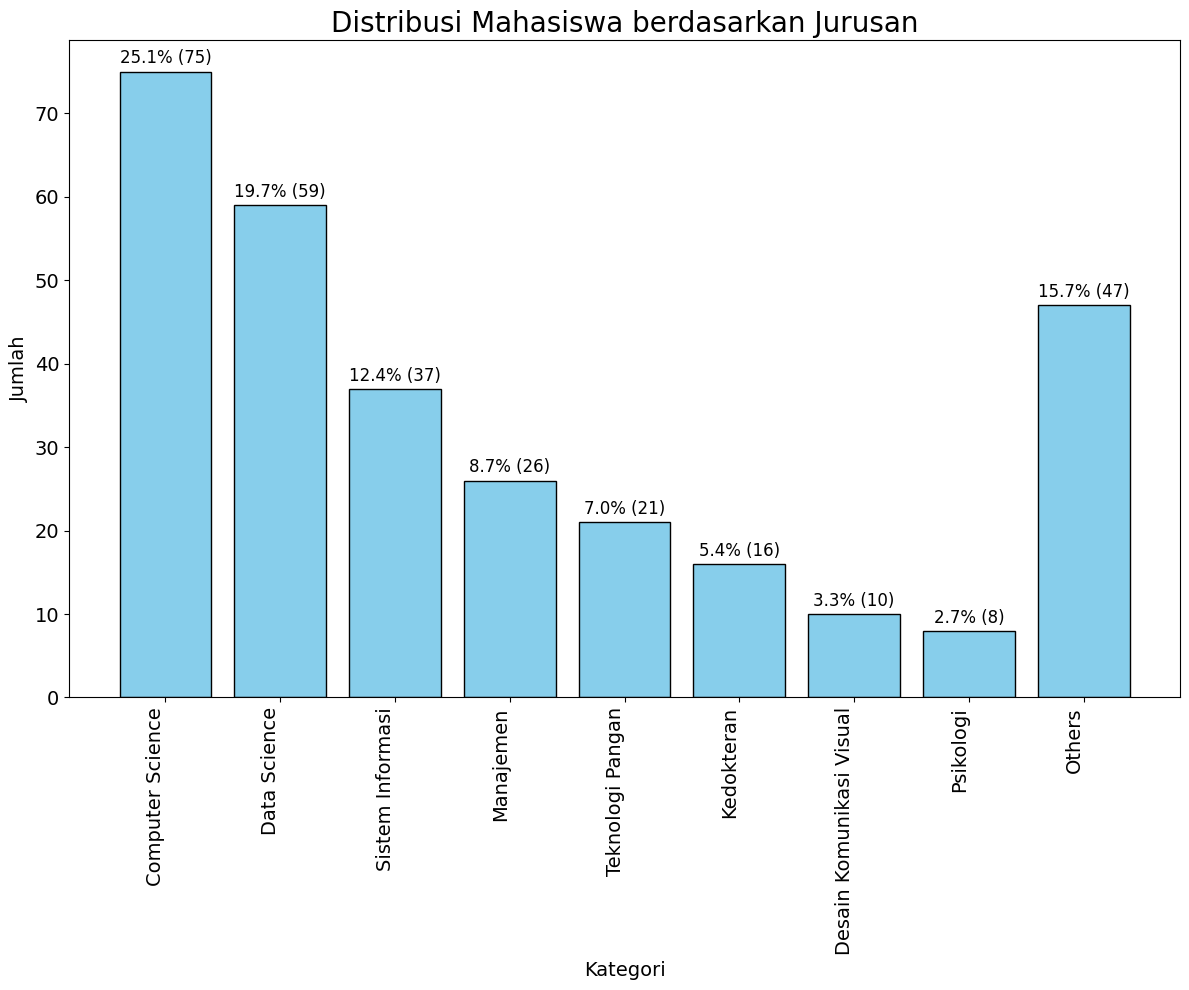

In [ ]:
plot_distribution(df_demografis,
                  column='Mapped_Program',
                  title='Distribusi Mahasiswa berdasarkan Jurusan',
                  threshold=0.02,
                  color='skyblue',
                  sort_index=False)

## **EDA sebelum Preprocessing**

In [ ]:
df_preprocess['word_count'] = df_preprocess['text'].apply(lambda x: len(str(x).split()))

mean_word_count = df_preprocess['word_count'].mean()
print("Rata-rata jumlah kata per ulasan:", mean_word_count)

Rata-rata jumlah kata per ulasan: 26.970099667774086


In [ ]:
mean_word_count = df_preprocess.groupby('sentiment')['word_count'].mean()
print("Rata-rata jumlah kata per", mean_word_count)

Rata-rata jumlah kata per sentiment
negative    27.920266
positive    26.019934
Name: word_count, dtype: float64


In [ ]:
all_words = [word for tokens in df_preprocess['text'] for word in tokens]

unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Jumlah kata unik: {num_unique_words}")

Jumlah kata unik: 79


### **1. WordCloud**

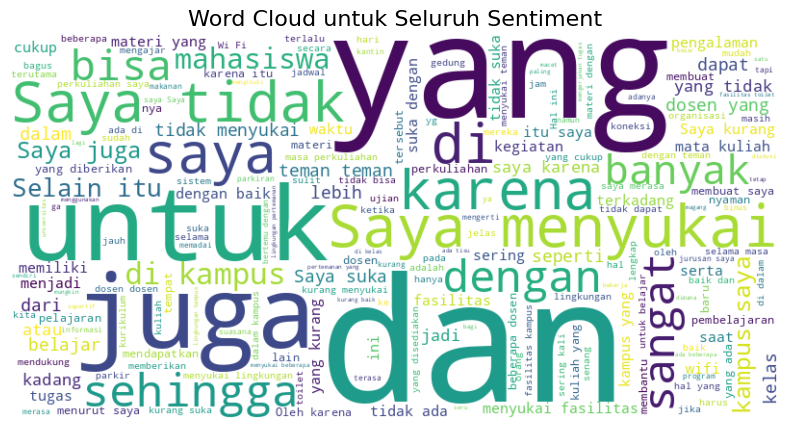

In [ ]:
combined_text = ' '.join(df_preprocess['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Seluruh Sentiment', fontsize=16)
plt.show()

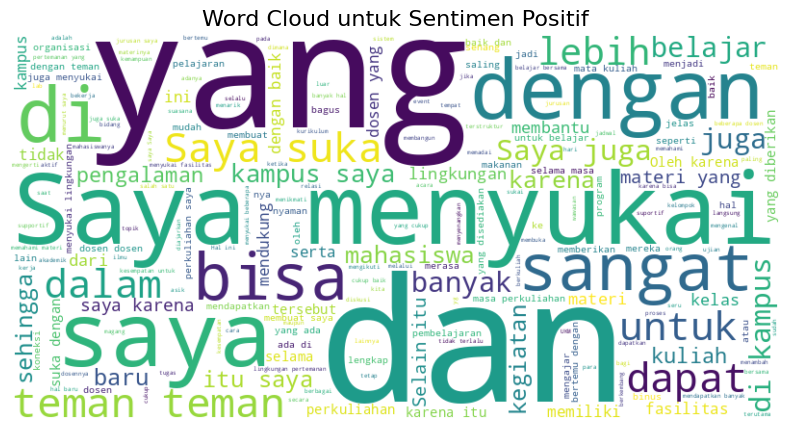

In [ ]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'positive']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif', fontsize=16)
plt.show()

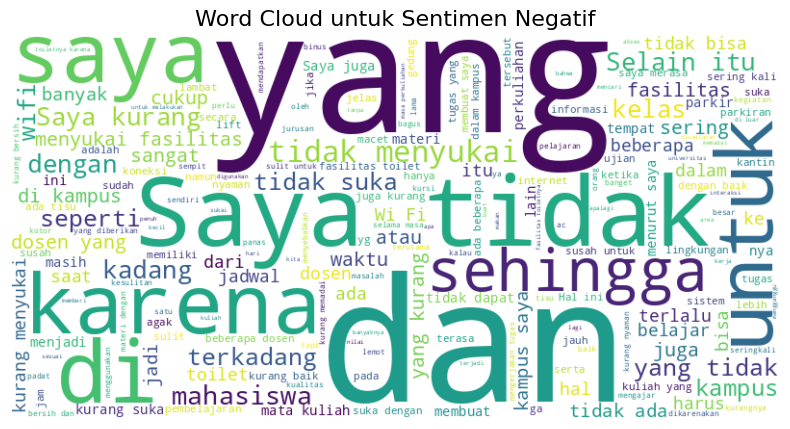

In [ ]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'negative']['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Negatif', fontsize=16)
plt.show()

### **2. Frekuensi Kata**

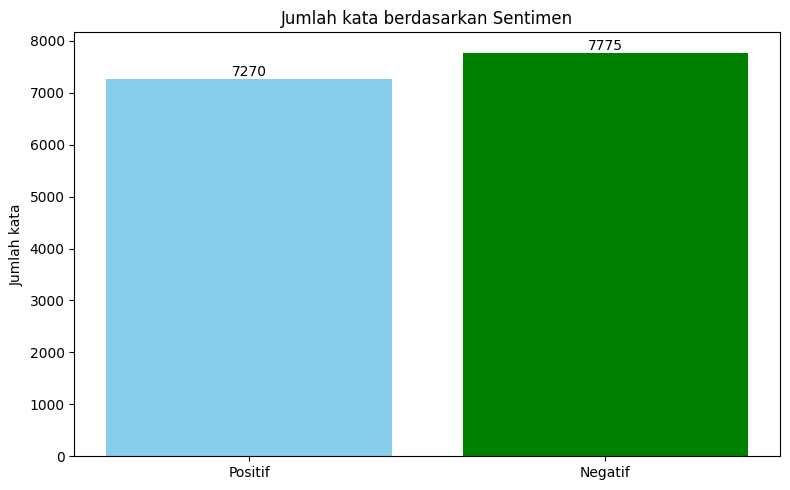

In [ ]:
total_words = df_preprocess['word_count'].sum()
positive_words = df_preprocess[df_preprocess['sentiment'] == 'positive']['word_count'].sum()
negative_words = df_preprocess[df_preprocess['sentiment'] == 'negative']['word_count'].sum()

categories = ['Positif', 'Negatif']
word_counts = [positive_words, negative_words]

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, word_counts, color=['skyblue', 'green'])
plt.ylabel('Jumlah kata')
plt.title('Jumlah kata berdasarkan Sentimen')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

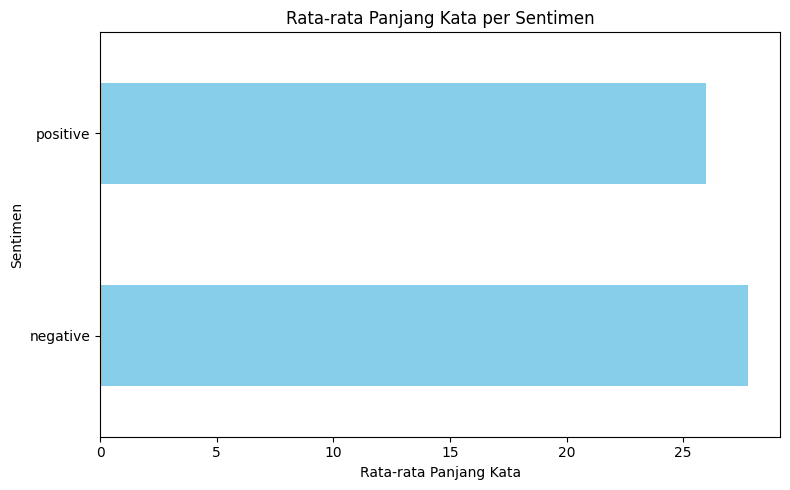

In [ ]:
average_length = df_preprocess.groupby('sentiment')['word_count'].mean()

plt.figure(figsize=(8, 5))
average_length.plot(kind='barh', color='skyblue')
plt.title('Rata-rata Panjang Kata per Sentimen')
plt.ylabel('Sentimen')
plt.xlabel('Rata-rata Panjang Kata')
plt.tight_layout()
plt.show()

In [ ]:
all_words = ' '.join(df_preprocess['text']).split()
positive_words = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'positive']['text']).split()
negative_words = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'negative']['text']).split()

top_all = Counter(all_words).most_common(10)
top_positive = Counter(positive_words).most_common(10)
top_negative = Counter(negative_words).most_common(10)

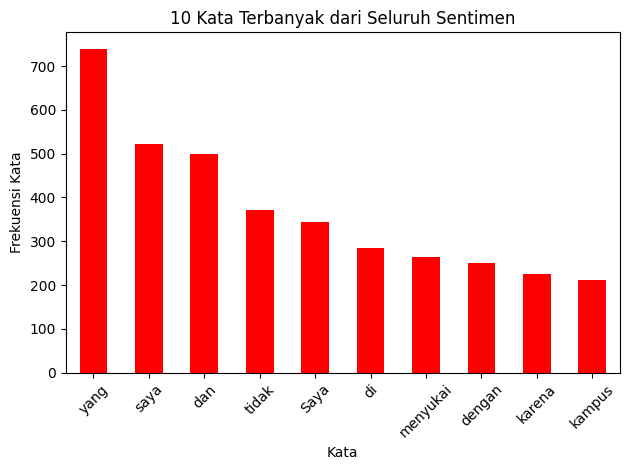

In [ ]:
df_all = pd.DataFrame(top_all, columns=['word', 'count'])
df_all.plot(kind='bar', x='word', y='count', legend=False, color='red', title='10 Kata Terbanyak dari Seluruh Sentimen')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

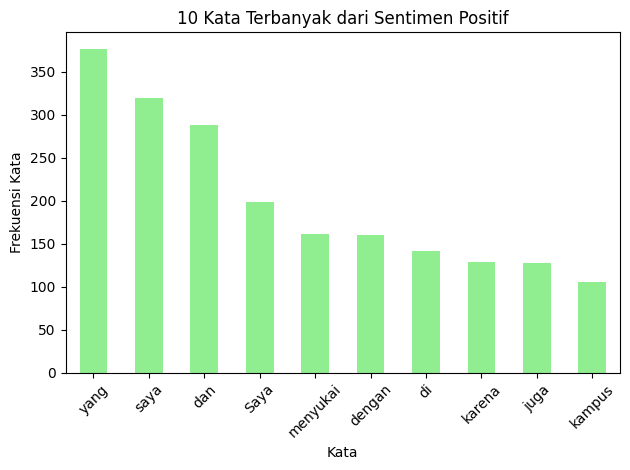

In [ ]:
# Positive
pd.DataFrame(top_positive, columns=['word', 'count']).plot(kind='bar', x='word', y='count',
    legend=False, color='lightgreen', title='10 Kata Terbanyak dari Sentimen Positif')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

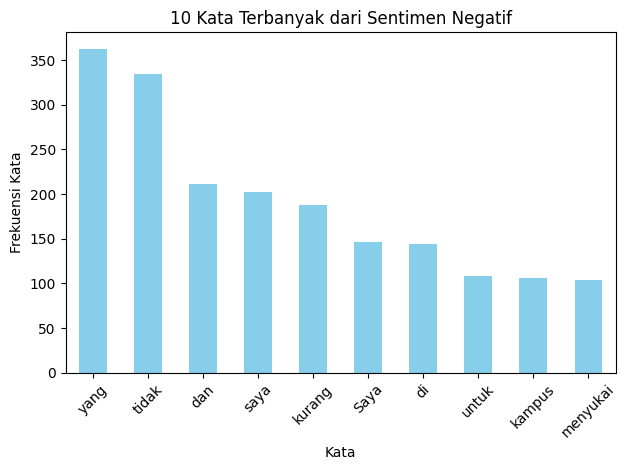

In [ ]:
# Negative
pd.DataFrame(top_negative, columns=['word', 'count']).plot(kind='bar', x='word', y='count',
    legend=False, color='skyblue', title='10 Kata Terbanyak dari Sentimen Negatif')
plt.ylabel('Frekuensi Kata')
plt.xlabel('Kata')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Data Cleansing & Preprocessing**

In [11]:
def split_data(df, validation_data=False):
    if validation_data:
        train_df, val_test_df = train_test_split(
            df, test_size=0.2, random_state=42, stratify=df['sentiment']
        )
        val_df, test_df = train_test_split(
            val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['sentiment']
        )

        print(f'Training shape: {train_df.shape}')
        print(f'Validation shape: {val_df.shape}')
        print(f'Test shape: {test_df.shape}')
        return train_df, val_df, test_df

    # Only train/test split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['sentiment']
    )
    print(f'Training shape: {train_df.shape}')
    print(f'Test shape: {test_df.shape}')
    return train_df, test_df

In [12]:
df_train, df_val, df_test = split_data(df_preprocess, validation_data=True)

Training shape: (481, 2)
Validation shape: (60, 2)
Test shape: (61, 2)


In [13]:
from normalization_dictionary import norm_dict

def correct_typos(text):
    for typo, correction in norm_dict.items():
        text = re.sub(typo, correction, text, flags=re.IGNORECASE)
    return text

# Contoh: "Saya sukaaaa sekali dengan kampus saya" -> "Saya suka sekali dengan kampus saya"
def reduce_extra_characters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

exception_words = ["tanya", 'punya', 'bertanya', 'hanya'] # Kata-kata yang berakhiran dengan -nya namun memiliki arti sendiri
def split_nya(word):
    if word in exception_words:
        return word
    return re.sub(r'(.*?)nya$', r'\1 nya', word)

def process_split_nya(review):
    words = review.split()
    processed_words = [split_nya(word.strip()) for word in words]
    return ' '.join(processed_words)

In [39]:
from exclude_words import exclude_lemmatization
from exclude_words import exclude_stemming
from exclude_words import exclude_stopwords
from nlp_id.stopword import StopWord
from nlp_id.tokenizer import Tokenizer

stopword = StopWord()
tokenizer = Tokenizer()

# Menambahkan kata untuk stop words
stop_words = stopword.get_stopword()
custom_stopwords = ['nya', 'ya', 'nih']
stop_words.append(custom_stopwords)

def text_preprocessing(text):
    # Mengubah ke huruf kecil
    text = text.lower()

    # Menghapus simbol dan angka
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)

    # Memisahkan kata dengan akhiran -nya
    text = process_split_nya(text)

    # Membenarkan typo dan huruf yang berlebih
    text = correct_typos(text)
    text = reduce_extra_characters(text)

    # Menghapus spasi yang berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # # Tokenisasi menggunakan Tokenizer dari nlp_id
    tokens = tokenizer.tokenize(text)

    filtered_tokens = [word for word in tokens if word not in stop_words]

    processed_text = " ".join(filtered_tokens)

    return processed_text

In [34]:
sample_text = "Fasilitas kampus Alam Sutera sangat bagus. Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi binus lemot. males mengetahui"
print("Sample text:", sample_text)
processed_tokens = text_preprocessing(sample_text)
print("Processed Tokens:", processed_tokens)

Sample text: Fasilitas kampus Alam Sutera sangat bagus. Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi binus lemot. males mengetahui
Processed Tokens: fasilitas kampus alam sutera bagus pelajaran lab diajarkan asisten mengerti materi binus lambat malas


In [35]:
df_preprocess['cleaned_text_nlpid'] = df_preprocess['text'].apply(text_preprocessing)

### Stanza for lemma

In [ ]:
nlp = stanza.Pipeline(lang='id', processors='tokenize,mwt,pos,lemma')
doc = nlp("Fasilitas kampus Alam Sutera sangat bagus. Pelajaran lab diajarkan oleh asisten yang sangat mengerti materi binus lemot. males mengetahui")
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| pos       | gsd_charlm   |
| lemma     | gsd_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


word: Fasilitas 	lemma: fasilitas
word: kampus 	lemma: kampus
word: Alam 	lemma: alam
word: Sutera 	lemma: sutera
word: sangat 	lemma: sangat
word: bagus 	lemma: bagus
word: . 	lemma: .
word: Pelajaran 	lemma: pelajaran
word: lab 	lemma: lab
word: diajarkan 	lemma: ajar
word: oleh 	lemma: oleh
word: asisten 	lemma: asisten
word: yang 	lemma: yang
word: sangat 	lemma: sangat
word: mengerti 	lemma: mengerti
word: materi 	lemma: materi
word: binus 	lemma: binus
word: lemot 	lemma: lemot
word: . 	lemma: .
word: males 	lemma: males
word: mengetahui 	lemma: ketahui


In [ ]:
from mpstemmer import MPStemmer
from nlp_id.lemmatizer import Lemmatizer
from nlp_id.tokenizer import Tokenizer
from nlp_id.stopword import StopWord

from exclude_words import exclude_lemmatization
from exclude_words import exclude_stemming
from exclude_words import exclude_stopwords

stemmer = MPStemmer()
lemmatizer = Lemmatizer()
tokenizer = Tokenizer()
stopword = StopWord()

# Menambahkan kata untuk stop words
stopword = stopword.get_stopword()
custom_stopwords = {'nya', 'ya', 'nih'}
stop_words = stopword.append(custom_stopwords)

def text_preprocessing(text):
    # Mengubah ke huruf kecil
    text = text.lower()

    # Menghapus simbol dan angka
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)

    # Memisahkan kata dengan akhiran -nya
    text = process_split_nya(text)

    # Membenarkan typo dan huruf yang berlebih
    text = correct_typos(text)
    text = reduce_extra_characters(text)

    # Menghapus spasi yang berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenisasi menggunakan Tokenizer dari nlp_id
    tokens = tokenizer.tokenize(text)

    # Lematisasi dan hapus stopwords
    lemmatized_tokens = [
        lemmatizer.lemmatize(word) if (word not in exclude_stopwords and word not in exclude_lemmatization) else word
        for word in tokens
        if word not in stopword or word in exclude_stopwords
    ]

    # Stemming setelah lemmatization
    stemmed_tokens = [
        stemmer.stem(word) if (word not in exclude_stopwords and word not in exclude_stemming) else word
        for word in lemmatized_tokens
    ]

    # Gabungkan kembali menjadi teks
    processed_text = ' '.join(stemmed_tokens)

    return processed_text

# **EDA after preprocessing**

In [ ]:
df_preprocess['word_count_cleaned'] = df_preprocess['cleaned_text'].apply(lambda x: len(str(x).split()))

mean_word_count = df_preprocess['word_count_cleaned'].mean()
print("Rata-rata jumlah kata per ulasan:", mean_word_count)

Rata-rata jumlah kata per ulasan: 13.780357142857143


In [ ]:
mean_word_count = df_preprocess.groupby('sentiment')['word_count_cleaned'].mean()
print("Rata-rata jumlah kata per", mean_word_count)

Rata-rata jumlah kata per sentiment
negative    14.678571
positive    12.882143
Name: word_count_cleaned, dtype: float64


In [ ]:
all_words = [word for tokens in df_preprocess['cleaned_text'] for word in tokens]

unique_words = set(all_words)
num_unique_words = len(unique_words)

print(f"Jumlah kata unik: {num_unique_words}")

Jumlah kata unik: 27


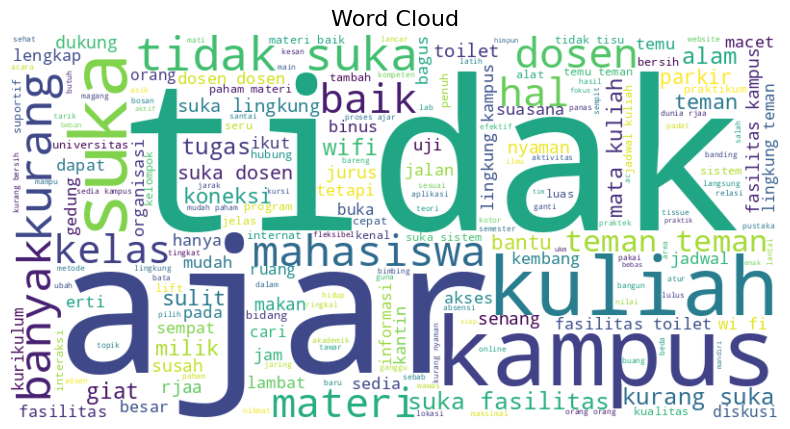

In [ ]:
combined_text = ' '.join(df_preprocess['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud', fontsize=16)
plt.show()

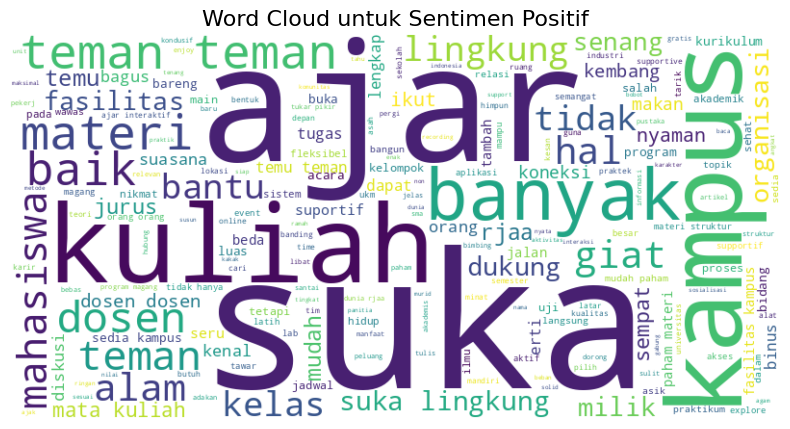

In [ ]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'positive']['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif', fontsize=16)
plt.show()

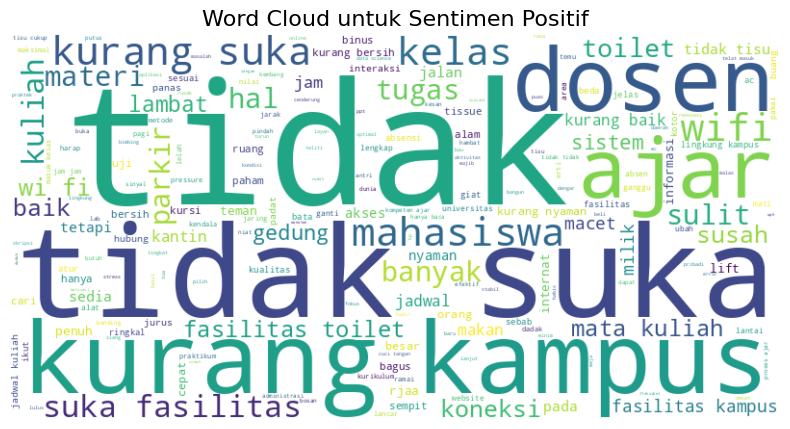

In [ ]:
combined_text = ' '.join(df_preprocess[df_preprocess['sentiment'] == 'negative']['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(combined_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Sentimen Positif', fontsize=16)
plt.show()

# **Menyimpan hasil preprocessing**

In [36]:
df_modeling_bertopic = df_preprocess[['cleaned_text_nlpid', 'sentiment']]
df_modeling_bertopic.to_csv('df_modeling_bertopic.csv', index=False)

In [ ]:
# df_train_final = df_train[['cleaned_text', 'sentiment']].to_csv("df_train.csv", index=False)
# df_val_final = df_val[['cleaned_text', 'sentiment']].to_csv("df_val.csv", index=False)
# df_test_final = df_test[['cleaned_text', 'sentiment']].to_csv("df_test.csv", index=False)